In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast
import string
import re
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from deep_translator import GoogleTranslator

In [6]:
def translate_by_division(row, source_lang='de', target_lang='en', num_parts=10):

    if not isinstance(row, str):
        return row
    num_parts = max(num_parts, 1)
    num_parts = min(num_parts, len(row)) if len(row) > 0 else 1
    part_length = max(len(row) // num_parts, 1)

    chunks = [row[i:i+part_length] for i in range(0, len(row), part_length)]
    
    translated_chunks = []
    for chunk in chunks:
        try:
            translated_chunk = GoogleTranslator(source=source_lang, target=target_lang).translate(chunk)
            if translated_chunk is not None:  #
                translated_chunks.append(translated_chunk)
        except Exception as e:
            continue  
    
    return ' '.join(translated_chunks)


In [48]:
df_keys = pd.read_csv('../data/processed/keyword_list.csv')

In [62]:
df = pd.read_csv('../data/processed/review_data_berlin_labeledsentences.csv')

In [49]:
df_keys

,Unnamed: 0,0
0,0,disappointed
1,1,dull
2,2,tired
3,3,detract
4,4,loud
...,...,...
2262,2262,rain
2263,2263,too
2264,2264,confused
2265,2265,mistakes


In [47]:
#df['labeled_sentences_en'] = df.labeled_sentences.apply(lambda x: translate_by_division(x))

In [75]:
df['labeled_sentences'].iloc[0]

'[\'I was just expecting a garden but in my opinion it is more like a forest so I got disappointed.\', "A nice park to hangout or have a walk. Sadly the management probably doesn\'t have enough money to take more care of the garden part infront and on the backside of the castle.", \'Garden was very dull. Apart from a few buildings and the lake the central parterre was looking very tired with mean beds and pedestrian planting.\']'

In [76]:
all_sentences = []

# Iterate through each row in the DataFrame
for row in df['labeled_sentences']:
    # Remove unwanted characters and clean the string
    cleaned_row = row.replace("[", "").replace("]", "").replace("\\n", "").strip()
    # Split the text by ", '" to extract individual sentences
    sentences = cleaned_row.split(", '")
    # Append these sentences to the master list
    all_sentences.extend(sentences)

In [77]:
len(all_sentences)

1809

In [50]:
keywords = list(df_keys['0'])

In [51]:
len(keywords)

2267

In [66]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(all_sentences)

In [46]:
inertia_values = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(embeddings)
    inertia_values.append(kmeans.inertia_)

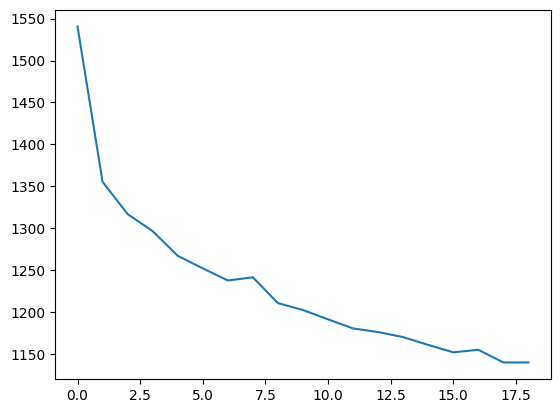

In [47]:
plt.plot(inertia_values)

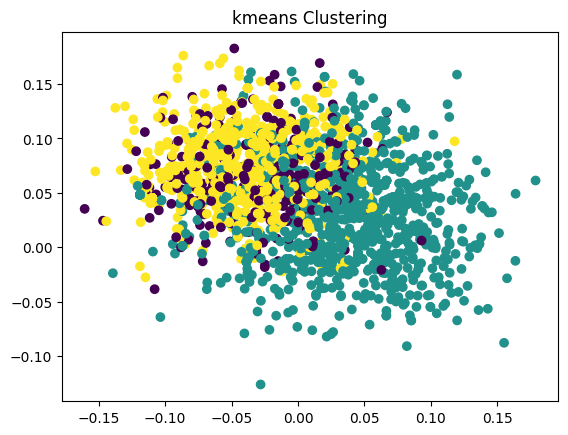

In [55]:
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(embeddings)

plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis')
plt.title('kmeans Clustering')
plt.show()

In [61]:
labels

NameError: name 'labels' is not defined

### bertTopic

In [14]:
from bertopic import BERTopic


In [31]:
import nltk
nltk.download('all')
from nltk.corpus import stopwords
import unidecode

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

In [25]:
def remove_stopwords(text: str, sw = stopwords.words('german')) -> str:
    '''
    This function will remove stopwords from the text
    
    Args:
        text: String of data you want to remove stopwords from
        sw: List of strings indicating the list of stopwords
        
    Returns:
        The input string with the stopwords removed.
    '''
    additional_sw = [
    'we', 'are', 'the', 'a', 'and', 'is', 'of', 'you', 'it', 'there', 'but',
    'at', 'for', 'be', 'as', 'with', 'have', 'on', 'only', 'in', 'this', 'that',
    'to', 'an', 'or', 'so', 'if', 'can', 'from', 'about', 'by', 'has', 'was',
    'not', 'they', 'their', 'them', 'your', 'which', 'do', 'did', 'does', 'how',
    'what', 'when', 'where', 'who', 'whom', 'why', 'all', 'any', 'our', 'us',
    'also', 'his', 'her', 'she', 'he', 'its', 'my', 'mine', 'yours', 'then',
    'more', 'less', 'very', 'most', 'some', 'few', 'being', 'into', 'over', 'under',
    'while', 'during', 'before', 'after', 'no', 'yes', 'each', 'other', 'out',
    'up', 'down', 'off', 'new', 'same', 'again', 'these', 'those', 'such',
    'just', 'now', 'like', 'here', 'where', 'therefore', 'hence', 'thus', 'yet'
]

    sw = sw + additional_sw
    
    text_list = text.split()
    text_list = [word for word in text_list if word.lower() not in sw]
    return ' '.join(text_list)

In [28]:
def remove_punctuation(text: str, punct: str = string.punctuation) -> str:
    '''
    This function will remove punctuations from the text.
    
    Args:
        text: String of data you want to remove punctuations from
        punct: String of punctuations
    
    Returns:
        The input string with the punctuations removed.
    '''
    cleaned_text = ''.join([char for char in text if char not in punct])
    return cleaned_text

In [29]:
def unicode(text: str) -> str:
    '''
    This function will make all the data unicoded. Meaning Â -> A
    
    Args:
        text: String of data you want to unicode
    
    Returns:
        The input string unicoded.
    '''
    return unidecode.unidecode(text)

In [30]:
def clean(text: str) -> str:
    '''
    This method will clean the input text through unidecoding and stopword and punctuation 
    removal.
    
    Args:
        text: String indicating the body of text you want to clean
    
    Returns:
        A string corresponding to the cleaned version of the input string.
    '''
    text = unicode(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    return text.lower()

In [112]:
df = pd.DataFrame(all_sentences)

In [113]:
df

,0
0,'I was just expecting a garden but in my opini...
1,Garden was very dull. Apart from a few buildin...
2,"'Gruselig, viel zu laut und jedes Mal viel zu ..."
3,Da wird seit über 2 Jahren an einem Fahrstuhl ...
4,Kein Rollstuhlgerechter Eingang. WLAN funktion...
...,...
1804,"Great location, very tasty food, and many vege..."
1805,"They only accept cash, even for bigger amounts..."
1806,The staffs are nice. The foods are delicious! ...
1807,"They only accept cash, even for bigger amounts..."


In [114]:
sentences_1 = list(df[0].apply(lambda x: clean(x)))

In [115]:
all_sentences

['\'I was just expecting a garden but in my opinion it is more like a forest so I got disappointed.\', "A nice park to hangout or have a walk. Sadly the management probably doesn\'t have enough money to take more care of the garden part infront and on the backside of the castle."',
 "Garden was very dull. Apart from a few buildings and the lake the central parterre was looking very tired with mean beds and pedestrian planting.'",
 "'Gruselig, viel zu laut und jedes Mal viel zu viel Verkehrs Chaos'",
 'Da wird seit über 2 Jahren an einem Fahrstuhl gebaut! Handwerker die dort tätig sind, um den Aufzug endlich einmal fertig zustellen, sind kaum zu sehen.Unmögliche Situation  auf der stark befahrenen Suarezstraße laufen zu müssen, nachdem der Kaiserdamm überquert wurde, um dann hinter der Baustelle, rechts auf den Bürgersteig zu kommen.Typisch das Versagen der BVG und des "Baustadtrates von CH" so etwas zu genehmigen/zu zulassen!Berliner Planung halt!\'',
 "Kein Rollstuhlgerechter Eingang.

In [ ]:
from bertopic import BERTopic
from sklearn.cluster import KMeans

cluster_model = KMeans(n_clusters=10)
topic_model = BERTopic(hdbscan_model=cluster_model)

In [123]:
from bertopic import BERTopic
topic_model = BERTopic(nr_topics=5)

In [131]:
topics, probs = topic_model.fit_transform(all_sentences)

In [132]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,574,-1_the_to_und_die,"[the, to, und, die, and, in, der, ist, of, nicht]","[""This next issue that I had was with this spe..."
1,0,587,0_the_and_of_to,"[the, and, of, to, in, park, is, but, it, not]","[```json\n\n ""It's a good park, but a bit w..."
2,1,566,1_die_der_und_nicht,"[die, der, und, nicht, ist, aber, es, auf, auc...","['Schöner, aber leider völlig schattenloser un..."
3,2,68,2_ok_taken_care_well,"[ok, taken, care, well, not, of, nice, decisio...","[Not well taken care of', Not well taken care ..."
4,3,14,3_closed_open_it_pm,"[closed, open, it, pm, on, website, was, not, ...","['It’s 11:43 pm, and it’s closed. Why is it wr..."


In [129]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,338,-1_atrocities_bullfight_sketchy_unclean,"[atrocities, bullfight, sketchy, unclean, excr...","[atrocities, bullfight, atrocities]"
1,0,1762,0_dirty_rubbish_homeless_aggressive,"[dirty, rubbish, homeless, aggressive, trash, ...","[dirty, dirty, dirty]"
2,1,138,1_overcrowded_dealers_construction_gentrification,"[overcrowded, dealers, construction, gentrific...","[overcrowded, overcrowded, overcrowded]"
3,2,17,2_pickpockets_robbed_robbery_offside,"[pickpockets, robbed, robbery, offside, cash, ...","[pickpockets, pickpockets, pickpockets]"
4,3,12,3_bottles_bottle_caps_cap,"[bottles, bottle, caps, cap, beer, glass, , , , ]","[bottles, bottles, bottles]"


In [106]:
topics_df['Representative_Docs']

0              [bullfight, bums, atrocities]
1                [rubbish, rubbish, rubbish]
2                      [dirty, dirty, dirty]
3    [overcrowded, overcrowded, overcrowded]
4             [graffiti, graffiti, graffiti]
5             [homeless, homeless, homeless]
6                [dealers, dealers, dealers]
7                         [ugly, ugly, ugly]
8                [junkies, junkies, junkies]
9                         [cold, cold, cold]
Name: Representative_Docs, dtype: object

In [97]:
topic_model.Representative_Docs

AttributeError: 'BERTopic' object has no attribute 'Representative_Docs'

In [128]:
topic_model.get_topic(0)

[('dirty', 0.10166332811917658),
 ('rubbish', 0.06163606718106225),
 ('homeless', 0.039111723179119796),
 ('aggressive', 0.03672731987115796),
 ('trash', 0.03424559507402399),
 ('garbage', 0.03424559507402399),
 ('junkies', 0.03424559507402399),
 ('drug', 0.03372430502891475),
 ('disgusting', 0.032964837915146455),
 ('dangerous', 0.032964837915146455)]